# Elastic net regression using grid search CV 
The following code is highly inspired by "https://github.com/fnauman/timeseries/blob/master/candydata/xgboost_pipeline_candy.ipynb" but modified to fit our data. The times series handling and use of TimeSeriesSplit is confirmed by https://github.com/carl24k/fight-churn


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score, median_absolute_error
from sklearn.metrics import make_scorer

In [2]:
# Defining different measures to evaluate performance 
# MAPE
def mean_absolute_percentage_error(y_true, y_pred, eps = 1e-8): 
    return np.mean(np.abs((y_true - y_pred) / (y_true))) * 100 

mape = make_scorer(mean_absolute_percentage_error, 
                   greater_is_better=False)

# SMAPE
def symmetric_mape(y_true, y_pred, eps = 1e-8):
    summ = ((np.abs(y_true) + np.abs(y_pred)) + eps)
    return np.mean(np.abs(y_pred - y_true) / summ) * 100

smape = make_scorer(symmetric_mape, 
                    greater_is_better=False)

def print_scores(y_test, y_pred):
    print(f"R2 score: {r2_score(y_test, y_pred)}")
    print(f"MSE score: {mean_squared_error(y_test, y_pred)}")
    print(f"MAE score: {mean_absolute_error(y_test, y_pred)}")
    print(f"Median AE score: {median_absolute_error(y_test, y_pred)}")
    print(f"MAPE score: {mean_absolute_percentage_error(y_test, y_pred)}")
    print(f"SMAPE score: {symmetric_mape(y_test, y_pred)}")

In [3]:
# Load in the time series
candy = pd.read_csv('dfV3.csv')
# Set the index equal to time stamp
candy["Unnamed: 0"] = pd.to_datetime(candy["Unnamed: 0"])
candy = candy.set_index('Unnamed: 0')


In [4]:
# Split the data into a train and test set
df_train, df_test = candy.iloc[:-9341], candy.iloc[-9341:]

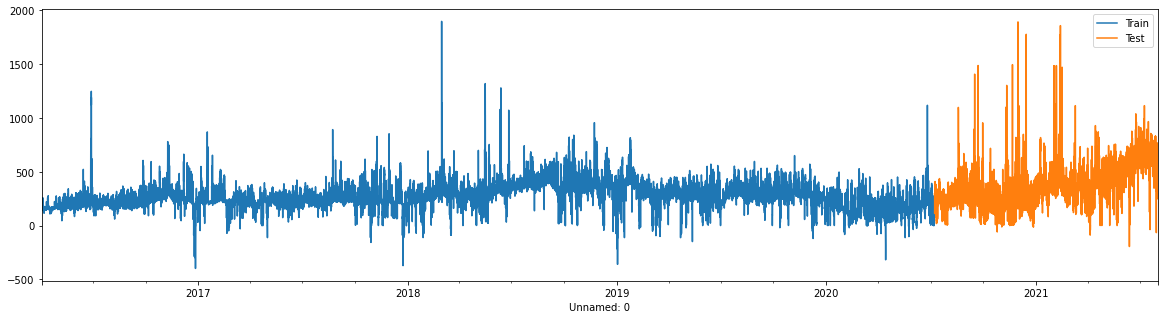

In [8]:
# Create plot visualizing the train and test data 

# Create an axis
fig, ax = plt.subplots(figsize = (20,5))

# Plot the train and test setsa dn show
df_train["DK2"].plot(ax=ax)
df_test["DK2"].plot(ax=ax)
#plt.axvline(x=4000, color='k', linestyle='--')
ax.legend(["Train", "Test"]);
plt.show()

In [5]:
# Create arrays for X and y for both training and testing data set. 
y_train = df_train[["DK2"]].to_numpy()
y_test  = df_test[["DK2"]].to_numpy()

X_train = df_train.copy()
X_test  = df_test.copy()

X_train.drop('DK2', inplace=True, axis=1)
X_test.drop('DK2', inplace=True, axis=1)

X_train = X_train.to_numpy()
X_test  = X_test.to_numpy()

In [13]:
# Define the pipeline for the Elastic Net regression
pipe_elasticnet = Pipeline([
                       #('polynomial', PolynomialFeatures(degree = 2, include_bias=True, interaction_only=True)),
                       ('scale', StandardScaler()),
                       ('elasticnet', ElasticNet())
                       ])

# Set the different values of lambdas to be searched through in the CV
params_elasticnet = {'elasticnet__alpha':np.logspace(-4,4,20), 'elasticnet__l1_ratio':np.linspace(0,1,10)},

In [14]:
# Define the type of cross validation used in the grid search. The TimesSeriesSplit 
# is the k-fold alternative for times series keeping the natural order in the data 
# i.e. one avoid using future observations to predict the past. 
ts_cv = TimeSeriesSplit(n_splits=20).split(X_train)

# Define the pipeline for the grid search using the LASSO pipeline and defined type of CV.
# Further, we apply the relevant scoring and parallelizes the CV
gs_elasticnet = GridSearchCV(pipe_elasticnet,
                        param_grid=params_elasticnet,
                        scoring='neg_mean_absolute_error',
                        cv=ts_cv,
                        verbose = 2,
                        n_jobs=4)

In [ ]:
# Show which observations that go into train and validation sets
# ts_cv = TimeSeriesSplit(n_splits=15, test_size=1)
# for train_index, test_index in ts_cv.split(X_train):
#     print("TRAIN:", train_index, "TEST:", test_index)


In [15]:
# Using the defined pipeline to fit our training set
gs_elasticnet.fit(X_train,y_train)
# And predicting using the elastic net regression model and the test data 
y_pred_elasticnet = gs_elasticnet.predict(X_test)

Fitting 20 folds for each of 200 candidates, totalling 4000 fits


<ipython-input-21-85811e7b88f5>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["pred"] = y_pred_elasticnet


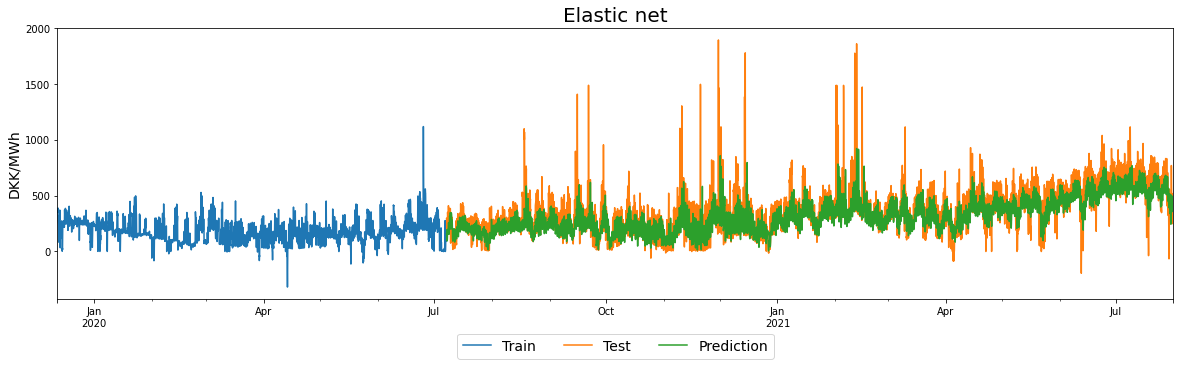

In [21]:
# Plot the actual values (train and test) and predicted valuesw
fig, ax = plt.subplots(figsize = (20,5))

df_train["DK2"][-5000:].plot(ax=ax)
df_test["DK2"].plot(ax=ax)

df_test["pred"] = y_pred_elasticnet
df_test["pred"].plot(ax=ax)
ax.set_xlabel("")
ax.set_ylabel("DKK/MWh", fontsize = 14)
ax.set_title("Elastic net", fontsize = 20)
ax.legend(["Train","Test","Prediction"],loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=False, ncol=3, fontsize = 14);
plt.show()

In [22]:
# Optimal lambda value from the grid search
print(f"Optimal lambda value in elastic net using grid search: {gs_elasticnet.best_params_}")

# Different scoring values
print_scores(y_test, y_pred_elasticnet)

Optimal lambda value in elastic net using grid search: {'elasticnet__alpha': 0.23357214690901212, 'elasticnet__l1_ratio': 0.7777777777777777}
R2 score: 0.6683292408380406
MSE score: 12995.350686047377
MAE score: 75.63852618504615
Median AE score: 56.58690880026502


<ipython-input-2-8fecfd3bbe5b>:4: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / (y_true))) * 100


MAPE score: inf
SMAPE score: 30.515128414340044


In [15]:
# Defining the final pipeline using the optimal lambda detected from the grid search 
finalpipe_elasticnet = Pipeline([
                       #('polynomial', PolynomialFeatures(degree = 2, include_bias=True, interaction_only=True)),
                       ('scale', StandardScaler()),
                       ('elasticnet', ElasticNet(alpha = gs_elasticnet.best_params_["elasticnet__alpha"], l1_ratio = gs_elasticnet.best_params_["elasticnet__l1_ratio"]))
                       ])

# Fitting the training data and predicting on the test data
finalpipe_elasticnet.fit(X_train,y_train)
finalpipe_elasticnet.predict(X_test)

array([155.81358979, 148.12684962, 140.1480559 , ..., 472.67318448,
       449.67620904, 438.6858836 ])

In [17]:
# Save coefficients to a dictionary
candy.drop("DK2", inplace = True, axis = 1)
d = {}
for i in range(len(candy.columns)):
    d[candy.columns[i]] = list(finalpipe_elasticnet.named_steps['elasticnet'].coef_)[i]


In [18]:
d

{'cloud_cover': -0.7874542843800665,
 'temp_soil_max_past1h': 17.428941347071238,
 'wind_max_per10min_past1h': -2.694062638527044,
 'acc_precip': -0.9340062690502787,
 'bright_sunshine': 0.5317050277090298,
 'mean_pressure': 1.470360319077954,
 'mean_radiation': -6.9188667046937224,
 'mean_relative_hum': -2.8721357796307427,
 'mean_temp': 0.0,
 'mean_wind_dir': -0.0,
 'mean_wind_speed': -3.5316135493153653,
 'temp_grass': -0.6052298957940698,
 'DK1_CP': 20.509194098696753,
 'DK2_CP': 10.006064217751849,
 'DK1_PP': 13.510618777481147,
 'DK2_PP': 10.860650284995344,
 'DK1_WP': -16.727000219683177,
 'DK2_WP': -15.925565835249962,
 'hour_1': 0.38507128431017573,
 'hour_2': 0.0,
 'hour_3': -0.25374476422177716,
 'hour_4': -0.6955151823004586,
 'hour_5': -0.7348890401509958,
 'hour_6': -0.0,
 'hour_7': 1.3310610461518702,
 'hour_8': 3.1611360397381048,
 'hour_9': 3.035033632293079,
 'hour_10': 0.7625482024661961,
 'hour_11': -0.6158802263725476,
 'hour_12': -1.1549511293945,
 'hour_13': -1.7